# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
import sys, os

# Make sure we're using the right kernel!
print(sys.executable)

/Users/andrei/anaconda3/envs/usdc/bin/python


In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


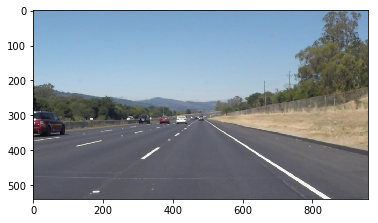

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_raw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Draws a set of lines on the given image."""
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn and the detected line list.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_raw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

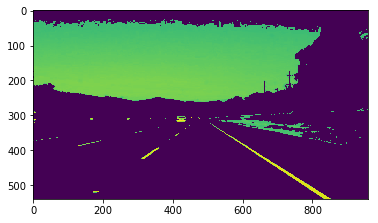

In [23]:
from ipywidgets import *
from sklearn.linear_model import RANSACRegressor, LinearRegression

sample_img = cv2.imread('test_images/solidWhiteRight.jpg')
# plt.imshow(sample_img)

img_gray = grayscale(sample_img)
img_intensity_mask = cv2.inRange(img_gray, 175, 255)
img_bright = (img_gray & img_intensity_mask)
plt.imshow(img_bright)

### Vanilla numpy regression

(50, 2)


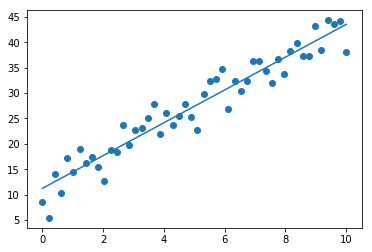

In [7]:
x = np.reshape(np.linspace(0, 10), (1, -1))
y = np.reshape(12 + 3 * x + np.random.randn(50) * 2.5, (1, -1))

xx = np.vstack((x, np.ones_like(x))).T
print(xx.shape)

# print(xx)

res = np.linalg.lstsq(xx, y.T)
slope = res[0][0]
bias = res[0][1]

plt.scatter(x, y)
plt.plot([np.min(x), np.max(x)], [np.min(x) * slope + bias, np.max(x) * slope + bias])

### RANSAC vs. Linear Regression in the face of structured noise

2.99836261855 12.016197395


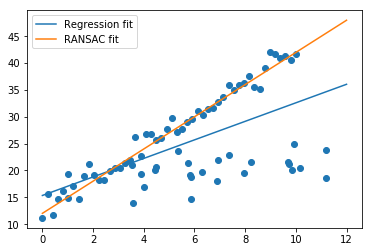

In [8]:
# RANSAC robust regression powered by scikit-learn

x = np.reshape(np.linspace(0, 10), (1, -1))
y = np.reshape(12 + 3 * x + np.random.randn(50) * 1.5, (1, -1))

# Add some spurious measurements, i.e., structured noise
# which is NOT vanilla gaussian noise, in order to throw off
# a non-robust estimator such as linear regression.
blob = np.random.randn(2, 25) * 2.5 + [[7], [20]]
bx = np.reshape(blob[0, :], (1, -1))
by = np.reshape(blob[1, :], (1, -1))
x = np.hstack((x, bx)).T
y = np.ravel(np.hstack((y, by)))

plt.scatter(x.T, y.T)

lr = LinearRegression()
lr.fit(x, y)

ps = np.reshape(np.linspace(0, 12), (-1, 1))
plt.plot(ps, lr.predict(ps), label="Regression fit")

ransac = RANSACRegressor()
ransac.fit(x, y)

imask = ransac.inlier_mask_
x_in = x[imask, :]
y_in = y[imask]
inlier_reg = LinearRegression().fit(x_in, y_in)
print(inlier_reg.coef_[0], inlier_reg.intercept_)


plt.plot(ps, ransac.predict(ps), label="RANSAC fit")

plt.legend()


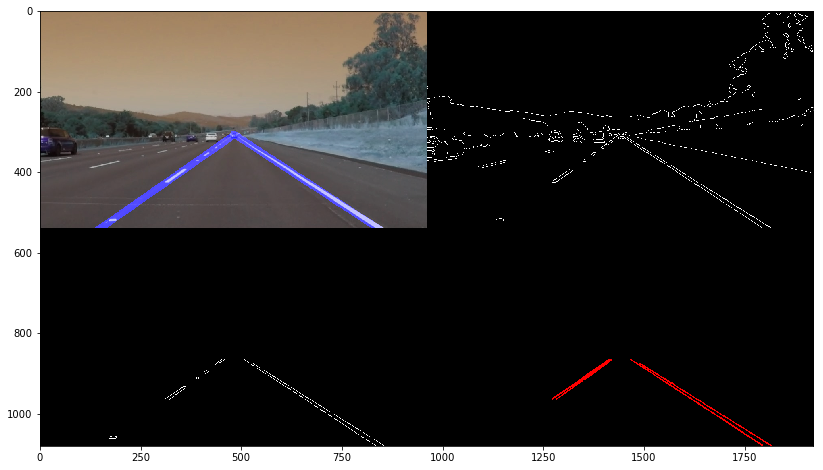

In [55]:
def fit_line(lines):
    """Converts a set of raw lines to a single estimate.
    
    Used to extract a single line equation from all the little 
    lines corresponding to a single lane line.
    
    The individual points are used in a RANSAC line fitting scheme,
    weighted by the squared lengths of their segments.
    """
    
    # Take all xs and ys in the lines independently, and fit
    # mother-line to all of them using RANSAC.
    xs = [l[0] for l in lines] + [l[2] for l in lines]
    ys = [l[1] for l in lines] + [l[3] for l in lines]
    xs = np.reshape(xs, (-1, 1))
    ys = np.array(ys)
    
    # We give more weight to points belonging to longer lines!
    line_len_sq = lambda l: (l[0]-l[2])*(l[0]-l[2]) + (l[1]-l[3])*(l[1]-l[3])
    lengths = np.array([line_len_sq(l) for l in lines])
    max_len = max(lengths)
    lengths = np.reshape(lengths / max_len, (-1, 1))
    weights = np.zeros((xs.shape[0], 1))
    weights[0::2] = lengths
    weights[1::2] = lengths
    weights = np.ravel(weights)
    
    ransac = RANSACRegressor().fit(xs, ys, weights)
    
    # A quirk in scikit-learn, but we have to refit a linear
    # regression on the detected inliers to get the actual
    # coefficients.
    in_mask = ransac.inlier_mask_
    xs_in = xs[in_mask, :]
    ys_in = ys[in_mask]
    inlier_fit = LinearRegression().fit(xs_in, ys_in)
    slope = inlier_fit.coef_[0]
    intercept = inlier_fit.intercept_
    
    return slope, intercept
    

def draw_lines(lane_detector, img, lines, color=[255, 0, 0], thickness=2):
    """Detects and draws the left and right lane markers.
    
    Uses the slope of the individual segments to partition them into
    left and right bins, discarding outliers with slopes too far from
    the expected ones.
    
    The function then uses RANSAC to robustly fit a line to the left
    and right segment clouds, respectively.
    
    If available, a history of past lane marker parameters is used
    to smooth the current measurement, making it more robust to
    momentary jitter.
    
    Returns:
        A copy of the input `img` with the lane markers rendered on it.
    """
    left_side = []
    right_side = []
    h = img.shape[0]
    w = img.shape[1]
    
    # "Canonical" angles determined empirically.
    right_lane_base = math.radians(+30)
    left_lane_base = math.radians(-35)
    
    # These variables control how much slack we allow on the slopes of raw
    # lines in order to consider them either left or right marker components.
    leeway_below = 0.85
    leeway_above = 1.15
    
    # Can fall back to history only up to 3 times in a row.
    MAX_RECOVERIES = 3
    
    # First, we roughly partition the line segments into left and right bins.
    # This is done purely based on their orientation.
    for line in lines:
        x1 = line[0][0]
        y1 = line[0][1]
        x2 = line[0][2]
        y2 = line[0][3]
        slope = math.atan2(y2 - y1, x2 - x1)
        
        # The traffic image is actually flipped. The (0, 0) origin is 
        # on the TOP-RIGHT!
        if slope > (right_lane_base * leeway_below) and slope < (right_lane_base * leeway_above):
            right_side.append((line, slope))
        elif slope > (left_lane_base * leeway_above) and slope < (left_lane_base * leeway_below):
            left_side.append((line, slope))
              
#     med_left_slope = np.median([slope for _, slope in left_side])
#     med_right_slope = np.median([slope for _, slope in right_side])
#     print("Median left slope: {}".format(med_left_slope))
#     print("Median right slope: {}".format(med_right_slope))
    
    # If either side has no associated markers, we try to give our best guess
    # using our history. If we see we're on a detection failure streak
    # (controlled by the MAX_RECOVERIES constant), we signal a fatal error.
    if np.shape(left_side)[0] == 0 or np.shape(right_side)[0] == 0:
        if len(lane_detector.marker_history) > 0:
            # Will recover from history...
            lane_detector.recoveries += 1
            if lane_detector.recoveries > MAX_RECOVERIES:
                print("GENERAL TRACKING FALURE. Apply brakes or something!")
                return np.zeros_like(img)
            
            print("Recovering from history...")            
            left_s, left_i, right_s, right_i = lane_detector.marker_history[-1]
        else:
            print("Warning, no markers found, and no history to fall back on!")
            return np.zeros_like(img)
    else:
        # We detected some markers successfully.
        recoveries = 0
        left_side_lines = [line[0] for (line, slope) in left_side]
        left_lane_line = fit_line(left_side_lines)
        right_side_lines = [line[0] for (line, slope) in right_side]
        right_lane_line = fit_line(right_side_lines)

        left_s, left_i = left_lane_line
        right_s, right_i = right_lane_line
    
    # Manage keeping track of the lane marker parameter history, for
    # increased robustness, and to reduce jitter.
    lane_detector.marker_history.append((left_s, left_i, right_s, right_i))
    if len(lane_detector.marker_history) > 1:
        # Smooth values based on (very) recent history
        smooth_hist_size = 5
        count = min(smooth_hist_size + 1, len(lane_detector.marker_history))
        recent = lane_detector.marker_history[-count:]
        
        left_s_hist, left_i_hist, right_s_hist, right_i_hist = zip(*recent)
        
        # TODO-LOW(andrei): More weight to more recent values.
        left_s = np.mean(left_s_hist)
        left_i = np.mean(left_i_hist)
        right_s = np.mean(right_s_hist)
        right_i = np.mean(right_i_hist)
    
    # Render the detected lane limits on a copy of the input frame.
    line_buf = np.zeros_like(img)
    cv2.line(line_buf,
             (0, int(left_i)),
             (w//2, int(left_i + w//2 * left_s)),
             color, thickness)
    cv2.line(line_buf,
         (w//2, int(right_i + w//2 * right_s)),
         (w, int(right_i + w * right_s)),
         color, thickness)
    
    return weighted_img(line_buf, np.copy(img))
       
def detect_lane(lane_detector, img, blur_kernel_size,
      canny_thresh_low, canny_thresh_high,
      hough_threshold, hough_min_line_length, hough_max_line_gap, plot=False):
    """Detects lane markers in the given frame.
    
    Separate from `LaneDetector` simply to allow exploration using Jupyter
    interactive controls for parameter tweaking.
    
    Returns:
        A copy of the frame with the lanes marked.
        
    Notes:
        The reason this function returns a full drawn-on frame is because
        of the nature of the assignment.
    """
    
    if canny_thresh_low > canny_thresh_high:
        print("Invalid edge detection thresholds yo.")
        return
    
    # Distance resolution of the discretised Hough space.
    hough_rho_res = 2
    # Angular resolution of the discretised Hough space.
    hough_theta_res = np.pi / 180
    # Minimum brightness used in color thresholding
    min_brightness = 125
    
    h = img.shape[0]
    w = img.shape[1]
    roi_vertices = [np.array([
        [w * 0.10, h], [w * 0.47, h * 0.60], [w * 0.53, h * 0.60], [w * 0.95, h]
    ], dtype=np.int32)]
    
    # Threshold the image so we don't look at really dark pixels.
    # Note that this doesn't seem to help too much in terms of accuracy, but
    # it does seem to improve performance a little.
#     img_gray = grayscale(img)
#     img_intensity_mask = cv2.inRange(img_gray, min_brightness, 255)
#     img_bright = img_gray & img_intensity_mask
    
    img_blur = gaussian_blur(img, blur_kernel_size)
    edge_img = canny(img_blur, canny_thresh_low, canny_thresh_high)
    edge_roi_img = region_of_interest(edge_img, roi_vertices)
    line_img, raw_lines = hough_lines(
        edge_roi_img, hough_rho_res, hough_theta_res, hough_threshold,
        hough_min_line_length, hough_max_line_gap)
    
    # Fuses the detected raw lines, superimposing them onto the
    # video frame.
    # TODO-LOW(andrei): Separate actual lane detection from rendering.
    img_out = draw_lines(lane_detector, img, raw_lines, [0, 0, 255], 15)

    # Used for generating the combined debug output.
    edge_img_col = cv2.cvtColor(edge_img, cv2.COLOR_GRAY2RGB)
    edge_roi_img_col = cv2.cvtColor(edge_roi_img, cv2.COLOR_GRAY2RGB)
    
    combined = np.vstack((
        np.hstack((img_out, edge_img_col)),
        np.hstack((edge_roi_img_col, line_img))
    ))
    
    if plot:
        plt.figure(figsize=(16, 8))
        plt.imshow(combined, cmap=plt.cm.gray)
    else:
        return combined

class LaneDetector(object):
        
    def __init__(self):
        # Keeps track of how many frames in a row we've had to fall back
        # to the measurement history due to a lane detection failure in
        # the current frame.
        self.recoveries = 0
        
        # Keeps track of a brief history of lane markers to reduce
        # noise. Based on the assumption that the lane boundaries
        # don't change erratically between frames. This should hold
        # even when the car is turning, unless it's in some sort of
        # drift competition, in which case all bets are off.
        self.marker_history = []
        
        # Core parameters used by the per-frame lane detection.
        self.blur_kernel_size = 11
        self.canny_thresh_low = 35
        self.canny_thresh_high = 90
        self.hough_threshold = 30
        self.hough_min_line_length = 25
        self.hough_max_line_gap = 30
        
    def process_frame(self, frame_image):
        return detect_lane(
            self,
            frame_image,
            self.blur_kernel_size,
            self.canny_thresh_low,
            self.canny_thresh_high,
            self.hough_threshold,
            self.hough_min_line_length,
            self.hough_max_line_gap,
            plot=False)
    
# The default values are approximately the best values.
interactive(detect_lane,
    lane_detector=fixed(LaneDetector()),
    img=fixed(sample_img),
    blur_kernel_size=IntSlider(min=1, max=49, step=2, value=11, description="Gaussian Blur Kernel Size"),
    canny_thresh_low=IntSlider(min=10, max=100, value=35, description="Canny low threshold"),
    canny_thresh_high=IntSlider(min=10, max=100, value=90, description="Canny high threshold"),
    hough_threshold=IntSlider(min=1, max=50, value=30, description="Hough min votes in cell"),
    hough_min_line_length=IntSlider(min=10, max=150, value=25),
    hough_max_line_gap=IntSlider(min=1, max=150, value=30),
    plot=fixed(True))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [56]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [57]:
def process_video(video_clip, output_fpath):
    lane_detector = LaneDetector()
    # NOTE: this function expects color images, and the output will be
    # corrupted if grayscale ones are given.
    out_clip = video_clip.fl_image(lane_detector.process_frame)
    %time out_clip.write_videofile(output_fpath, audio=False)

In [58]:
%mkdir -p test_videos_output

Let's try the one with the solid white lane on the right first ...

In [59]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

process_video(clip1, white_output)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 31.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.87 s, sys: 2.95 s, total: 9.82 s
Wall time: 7.73 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [51]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4")

process_video(clip2, yellow_output)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:18<00:00, 37.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 14.4 s, sys: 6.42 s, total: 20.9 s
Wall time: 19 s


In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [60]:
challenge_output = 'test_videos_output/challenge.mp4'
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
process_video(clip3, challenge_output)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:16<00:00, 15.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 15.7 s, sys: 6.62 s, total: 22.3 s
Wall time: 18.5 s


In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))